In [41]:
#Pre-prep Downloads for Jupyter notebook Functioning
!pip install emoji

import nltk
nltk.download('punkt')

from nltk.corpus import stopwords
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import f1_score
from imblearn.over_sampling import RandomOverSampler

import emoji
import string

import random
random.seed(20)
np.random.seed(20)

In [43]:
import torch

# Check GPU availability
if torch.cuda.is_available():

    # Let PyTorch use GPU
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [44]:
# Transformers package from HuggingFace
!pip install -U transformers

In [45]:
#read in dataset in pandas format
dataset = pd.read_csv('/content/sample_data/airlines_reviews.csv', sep=',')
dataset.head()

,Title,Name,Review Date,Airline,Verified,Reviews,Type of Traveller,Month Flown,Route,Class,Seat Comfort,Staff Service,Food & Beverages,Inflight Entertainment,Value For Money,Overall Rating,Recommended
0,Flight was amazing,Alison Soetantyo,2024-03-01,Singapore Airlines,True,Flight was amazing. The crew onboard this fl...,Solo Leisure,December 2023,Jakarta to Singapore,Business Class,4,4,4,4,4,9,yes
1,seats on this aircraft are dreadful,Robert Watson,2024-02-21,Singapore Airlines,True,Booking an emergency exit seat still meant h...,Solo Leisure,February 2024,Phuket to Singapore,Economy Class,5,3,4,4,1,3,no
2,Food was plentiful and tasty,S Han,2024-02-20,Singapore Airlines,True,Excellent performance on all fronts. I would...,Family Leisure,February 2024,Siem Reap to Singapore,Economy Class,1,5,2,1,5,10,yes
3,“how much food was available,D Laynes,2024-02-19,Singapore Airlines,True,Pretty comfortable flight considering I was f...,Solo Leisure,February 2024,Singapore to London Heathrow,Economy Class,5,5,5,5,5,10,yes
4,“service was consistently good”,A Othman,2024-02-19,Singapore Airlines,True,The service was consistently good from start ...,Family Leisure,February 2024,Singapore to Phnom Penh,Economy Class,5,5,5,5,5,10,yes


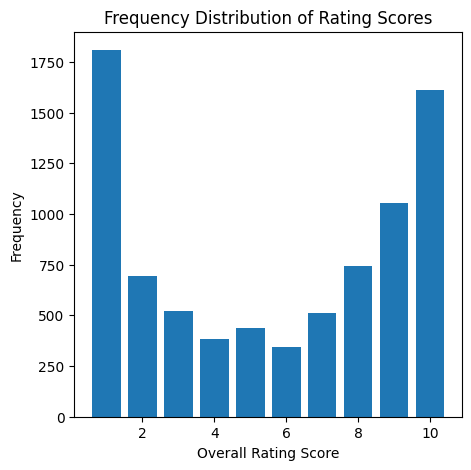

In [46]:
#Determine frequency of Overall Ratings Through Plot
freq_counts = dataset["Overall Rating"].value_counts()
rating_score = freq_counts.index

plt.figure(figsize=(5, 5))
plt.bar(rating_score, freq_counts)
plt.xlabel('Overall Rating Score')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Rating Scores')
plt.show()

In [47]:
#Create new function to convert Rating scores to 3 categories
#1-3, 4-7, 8-10 forms negative, neutral, positive [0,1,2]
def score_convert_senti(score):
    if score <= 3:
        return 0
    elif score >= 4 and score <= 7:
        return 1
    elif score >= 8:
        return 2

#Create new column, convert scoring into 3 categories
dataset["Sentiment"] = dataset["Overall Rating"].apply(score_convert_senti)

#dataset has derived sentiment column added
dataset.head()

,Title,Name,Review Date,Airline,Verified,Reviews,Type of Traveller,Month Flown,Route,Class,Seat Comfort,Staff Service,Food & Beverages,Inflight Entertainment,Value For Money,Overall Rating,Recommended,Sentiment
0,Flight was amazing,Alison Soetantyo,2024-03-01,Singapore Airlines,True,Flight was amazing. The crew onboard this fl...,Solo Leisure,December 2023,Jakarta to Singapore,Business Class,4,4,4,4,4,9,yes,2
1,seats on this aircraft are dreadful,Robert Watson,2024-02-21,Singapore Airlines,True,Booking an emergency exit seat still meant h...,Solo Leisure,February 2024,Phuket to Singapore,Economy Class,5,3,4,4,1,3,no,0
2,Food was plentiful and tasty,S Han,2024-02-20,Singapore Airlines,True,Excellent performance on all fronts. I would...,Family Leisure,February 2024,Siem Reap to Singapore,Economy Class,1,5,2,1,5,10,yes,2
3,“how much food was available,D Laynes,2024-02-19,Singapore Airlines,True,Pretty comfortable flight considering I was f...,Solo Leisure,February 2024,Singapore to London Heathrow,Economy Class,5,5,5,5,5,10,yes,2
4,“service was consistently good”,A Othman,2024-02-19,Singapore Airlines,True,The service was consistently good from start ...,Family Leisure,February 2024,Singapore to Phnom Penh,Economy Class,5,5,5,5,5,10,yes,2


In [48]:
#place reviews column textual data into list
reviews = dataset["Reviews"]
reviews_list = list(reviews)

In [49]:
#check for emojis
def contain_emoji(review):
    emoList = emoji.emoji_list(review)

    if emoList:
        return True

    return False


emoji_check = [contain_emoji(review) for review in reviews_list]

for i in range(len(emoji_check)):
    if emoji_check[i] == True:
        print("This is Review: " + str(i))
        print(reviews_list[i])

This is Review: 4708
  Valerie, terminal 2A, Paris CDG airport, left our hearts feeling warm with her compassion, patience and understanding whilst checking our bags. She showed us great kindness and deserves recognition for her customer service skills performed. Thank you to Valerie, if you read this, for all the small efforts which made our travels much easier while pregnant. Thank you for going above and beyond ☺️ Turkish airlines hires great assets to their company.


In [50]:
#Since emoji is present only in review 4708, de-emojize review 4708.
reviews_list_deemojize = reviews_list.copy()
reviews_list_deemojize[4708] = emoji.demojize(reviews_list_deemojize[4708], language='en')
print(reviews_list[4708])
print(reviews_list_deemojize[4708])

  Valerie, terminal 2A, Paris CDG airport, left our hearts feeling warm with her compassion, patience and understanding whilst checking our bags. She showed us great kindness and deserves recognition for her customer service skills performed. Thank you to Valerie, if you read this, for all the small efforts which made our travels much easier while pregnant. Thank you for going above and beyond ☺️ Turkish airlines hires great assets to their company.
  Valerie, terminal 2A, Paris CDG airport, left our hearts feeling warm with her compassion, patience and understanding whilst checking our bags. She showed us great kindness and deserves recognition for her customer service skills performed. Thank you to Valerie, if you read this, for all the small efforts which made our travels much easier while pregnant. Thank you for going above and beyond :smiling_face: Turkish airlines hires great assets to their company.


In [51]:
#Remove Punctuation
def remove_punc(review):
    ascii_to_translate = str.maketrans("", "", string.punctuation)
    review = review.translate(ascii_to_translate)
    return review

print(reviews_list_deemojize[4708])
reviews_list_noPunc = [remove_punc(review) for review in reviews_list_deemojize]
print(reviews_list_noPunc[4708])

  Valerie, terminal 2A, Paris CDG airport, left our hearts feeling warm with her compassion, patience and understanding whilst checking our bags. She showed us great kindness and deserves recognition for her customer service skills performed. Thank you to Valerie, if you read this, for all the small efforts which made our travels much easier while pregnant. Thank you for going above and beyond :smiling_face: Turkish airlines hires great assets to their company.
  Valerie terminal 2A Paris CDG airport left our hearts feeling warm with her compassion patience and understanding whilst checking our bags She showed us great kindness and deserves recognition for her customer service skills performed Thank you to Valerie if you read this for all the small efforts which made our travels much easier while pregnant Thank you for going above and beyond smilingface Turkish airlines hires great assets to their company


In [52]:
#Make text all lowercase
reviews_list_lower = [review.lower() for review in reviews_list_noPunc]
print(reviews_list_lower[4708])

  valerie terminal 2a paris cdg airport left our hearts feeling warm with her compassion patience and understanding whilst checking our bags she showed us great kindness and deserves recognition for her customer service skills performed thank you to valerie if you read this for all the small efforts which made our travels much easier while pregnant thank you for going above and beyond smilingface turkish airlines hires great assets to their company


In [53]:
bTokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [54]:
'''Y = dataset["Sentiment"]
X_train, X_temp, Y_train, Y_temp = train_test_split(reviews_list_lower, Y, test_size=0.2, random_state=20)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=20)'''
Y = dataset["Sentiment"]
X_train, X_test, Y_train, Y_test = train_test_split(reviews_list_lower, Y, test_size=0.2, random_state=20)

In [55]:
#Determine frequency of sentiments in training set
print(Y_train.value_counts())
#Sample counts not even => do RandomUnderSampler

Sentiment
2    2751
0    2384
1    1345
Name: count, dtype: int64


In [56]:
X_train_2d = np.array(X_train).reshape(-1, 1)
Y_train_2d = np.array(Y_train).reshape(-1, 1)

In [57]:
RandomOS = RandomOverSampler(random_state=20)
X_train_res, Y_train_res = RandomOS.fit_resample(X_train_2d, Y_train_2d)
X_train_res = pd.Series(X_train_res.flatten())
Y_train_res = pd.Series(Y_train_res.flatten())
print(Y_train_res.value_counts())

X_train = X_train_res
Y_train = Y_train_res

2    2751
0    2751
1    2751
Name: count, dtype: int64


In [58]:
X_train_tok = []
#X_val_tok = []
X_test_tok = []

def encode(reviewSet, newList):
  for review in reviewSet:
    encodedReview = bTokenizer.encode_plus(
      text = review,
      add_special_tokens = True,
      max_length=512,
      truncation=True,
    )
    newList.append(encodedReview)
  return newList

X_train_tok = encode(X_train, X_train_tok)
#X_val_tok = encode(X_val, X_val_tok)
X_test_tok = encode(X_test, X_test_tok)

In [59]:
print(X_train_tok[0])
print(bTokenizer.convert_ids_to_tokens(X_train_tok[0]['input_ids']))

{'input_ids': [101, 2006, 2051, 6712, 2013, 10204, 2044, 2019, 23589, 9405, 2832, 4435, 2047, 1037, 16703, 2487, 2007, 1996, 6745, 2065, 2063, 1998, 6625, 5898, 4272, 3626, 2020, 2012, 6528, 6024, 3768, 1997, 1996, 27120, 10026, 2106, 2025, 4025, 2000, 2031, 2904, 2326, 3798, 1998, 1996, 18640, 2001, 2200, 12382, 6195, 1996, 9367, 1997, 1996, 3462, 1996, 4690, 7529, 2364, 2001, 12090, 1998, 2348, 2009, 2001, 1037, 2440, 6644, 2035, 12183, 9804, 2020, 2800, 19394, 2015, 2000, 1996, 3626, 2005, 1037, 3962, 3238, 2392, 13697, 7062, 3019, 9724, 3514, 2192, 2843, 3258, 1998, 10918, 2800, 2004, 2092, 2004, 1037, 3696, 2005, 1037, 11394, 8934, 2006, 5227, 3369, 2004, 5115, 1999, 2000, 9960, 7078, 10392, 3452, 3462, 3325, 2007, 5037, 7608, 4102, 2000, 1996, 5377, 3465, 6276, 2006, 8013, 2326, 2011, 2060, 2647, 11363, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [60]:
bModel = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 3,)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
print(list(Y_train)[0])

2


In [62]:
##Create Dataloaders
BATCH_SIZE = 10

##first, create TensorDataset variable
#make batches same size [padding included]
#batch_first=True, pad along columns, padding_value is 0 as default
X_train_input = [torch.tensor(nSentence['input_ids']) for nSentence in X_train_tok]
X_train_input_pad = pad_sequence(X_train_input, batch_first=True)
X_train_mask = [torch.tensor(nSentence['attention_mask']) for nSentence in X_train_tok]
X_train_mask_pad = pad_sequence(X_train_mask, batch_first=True)

Y_train_input = torch.tensor(list(Y_train))
train_dataset = TensorDataset(X_train_input_pad, X_train_mask_pad, Y_train_input)

'''#Repeat for Val set
X_val_input = [torch.tensor(nSentence['input_ids']) for nSentence in X_val_tok]
X_val_input_pad = pad_sequence(X_val_input, batch_first=True)
X_val_mask = [torch.tensor(nSentence['attention_mask']) for nSentence in X_val_tok]
X_val_mask_pad = pad_sequence(X_val_mask, batch_first=True)

Y_val_input = torch.tensor(list(Y_val))
val_dataset = TensorDataset(X_val_input_pad, X_val_mask_pad, Y_val_input)'''

#Repeat for test set
X_test_input = [torch.tensor(nSentence['input_ids']) for nSentence in X_test_tok]
X_test_input_pad = pad_sequence(X_test_input, batch_first=True)
X_test_mask = [torch.tensor(nSentence['attention_mask']) for nSentence in X_test_tok]
X_test_mask_pad = pad_sequence(X_test_mask, batch_first=True)

Y_test_input = torch.tensor(list(Y_test))
test_dataset = TensorDataset(X_test_input_pad, X_test_mask_pad, Y_test_input)

#Create dataloaders
train_dataLoader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
#val_dataLoader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataLoader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


'''#TESTER
#Repeat for test set
X_TESTER_input = [torch.tensor(nSentence['input_ids']) for nSentence in X_train_tok[:100]]
X_TESTER_input_pad = pad_sequence(X_TESTER_input, batch_first=True) [:100]
X_TESTER_mask = [torch.tensor(nSentence['attention_mask']) for nSentence in X_train_tok[:100]]
X_TESTER_mask_pad = pad_sequence(X_TESTER_mask, batch_first=True) [:100]

Y_TESTER_input = torch.tensor(list(Y_train)[:100])
TESTER_dataset = TensorDataset(X_TESTER_input_pad, X_TESTER_mask_pad, Y_TESTER_input)

#Create dataloaders
TESTER_dataLoader = DataLoader(TESTER_dataset, batch_size=BATCH_SIZE)

#Repeat for test set
X_TESTTESTER_input = [torch.tensor(nSentence['input_ids']) for nSentence in X_test_tok[:100]]
X_TESTTESTER_input_pad = pad_sequence(X_test_input, batch_first=True) [:100]
X_TESTTESTER_mask = [torch.tensor(nSentence['attention_mask']) for nSentence in X_test_tok[:100]]
X_TESTTESTER_mask_pad = pad_sequence(X_test_mask, batch_first=True) [:100]

Y_TESTTESTER_input = torch.tensor(list(Y_test)[:100])
TESTTESTER_dataset = TensorDataset(X_TESTTESTER_input_pad, X_TESTTESTER_mask_pad, Y_TESTTESTER_input)

#Create dataloaders
TESTTESTER_dataLoader = DataLoader(TESTTESTER_dataset, batch_size=BATCH_SIZE)'''
#TESTER
#Repeat for test set
X_TESTER_input = [torch.tensor(nSentence['input_ids']) for nSentence in X_train_tok[:]]
X_TESTER_input_pad = pad_sequence(X_TESTER_input, batch_first=True) [:]
X_TESTER_mask = [torch.tensor(nSentence['attention_mask']) for nSentence in X_train_tok[:]]
X_TESTER_mask_pad = pad_sequence(X_TESTER_mask, batch_first=True) [:]

Y_TESTER_input = torch.tensor(list(Y_train)[:])
TESTER_dataset = TensorDataset(X_TESTER_input_pad, X_TESTER_mask_pad, Y_TESTER_input)

#Create dataloaders
TESTER_dataLoader = DataLoader(TESTER_dataset, batch_size=BATCH_SIZE)

#Repeat for test set
X_TESTTESTER_input = [torch.tensor(nSentence['input_ids']) for nSentence in X_test_tok[:]]
X_TESTTESTER_input_pad = pad_sequence(X_test_input, batch_first=True) [:]
X_TESTTESTER_mask = [torch.tensor(nSentence['attention_mask']) for nSentence in X_test_tok[:]]
X_TESTTESTER_mask_pad = pad_sequence(X_test_mask, batch_first=True) [:]

Y_TESTTESTER_input = torch.tensor(list(Y_test)[:])
TESTTESTER_dataset = TensorDataset(X_TESTTESTER_input_pad, X_TESTTESTER_mask_pad, Y_TESTTESTER_input)

#Create dataloaders
TESTTESTER_dataLoader = DataLoader(TESTTESTER_dataset, batch_size=BATCH_SIZE)

In [63]:
print(len(X_TESTER_mask_pad))
print(len(X_TESTTESTER_mask_pad))

8253
1620


In [64]:
#print(len(X_train_input_pad))
#print(len(Y_test))

In [65]:
#optimizer method
optimizer = torch.optim.AdamW(bModel.parameters(), lr = 1e-6,)

#epochs
EPOCHS = 3

#scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataset) * EPOCHS)

#loss function
loss_function = nn.CrossEntropyLoss()

In [66]:
#Train the BERT model
outputs = 0
counter = 0
bModel.to(device)
for i in range(EPOCHS):
  #inform model training beginning
  bModel.train()
  total_loss = 0

  for item in TESTER_dataLoader:
    #restart optimizer values
    optimizer.zero_grad()
    input_ids = item[0].to(device)
    attention_masks = item[1].to(device)
    labels = item[2].to(device)

    outputs = bModel(input_ids=input_ids,
                     attention_mask=attention_masks, labels=labels)
    loss = outputs.loss

    total_loss = total_loss + loss.item()

    loss.backward()
    optimizer.step()
    scheduler.step()
    counter += 1
    print("pass done" + str(counter))
  print("Average Train loss is: " + str(total_loss / len(TESTER_dataLoader)))

pass done1
pass done2
pass done3
pass done4
pass done5
pass done6
pass done7
pass done8
pass done9
pass done10
pass done11
pass done12
pass done13
pass done14
pass done15
pass done16
pass done17
pass done18
pass done19
pass done20
pass done21
pass done22
pass done23
pass done24
pass done25
pass done26
pass done27
pass done28
pass done29
pass done30
pass done31
pass done32
pass done33
pass done34
pass done35
pass done36
pass done37
pass done38
pass done39
pass done40
pass done41
pass done42
pass done43
pass done44
pass done45
pass done46
pass done47
pass done48
pass done49
pass done50
pass done51
pass done52
pass done53
pass done54
pass done55
pass done56
pass done57
pass done58
pass done59
pass done60
pass done61
pass done62
pass done63
pass done64
pass done65
pass done66
pass done67
pass done68
pass done69
pass done70
pass done71
pass done72
pass done73
pass done74
pass done75
pass done76
pass done77
pass done78
pass done79
pass done80
pass done81
pass done82
pass done83
pass done84
p

In [67]:
#Evaluation of Model
bModel.eval()
#total_eval_loss = 0
total_correct = 0
total_data_counter = 0
prediction_list = []
actual_list = []

with torch.no_grad():
  for item in TESTTESTER_dataLoader:
    input_ids = item[0].to(device)
    attention_masks = item[1].to(device)
    labels = item[2].to(device)

    outputs = bModel(input_ids=input_ids,
                     attention_mask=attention_masks)
    #loss = outputs.loss

    #get maximum value of each column, set prediction to that column
    predictions = torch.argmax(outputs.logits, dim=1)

    total_correct += (predictions == labels).sum().item()
    total_data_counter += labels.size(dim=0)
    prediction_list.extend(predictions.cpu().numpy())
    actual_list.extend(labels.cpu().numpy())
    #print(prediction_list)
    #print(actual_list)

    #print(outputs.logits)
    print("predictions: " + str(predictions))
    print("labels: " + str(labels))
    #total_eval_loss = total_eval_loss + loss.item()
  #actual_list = np.array(actual_list)
  #prediction_list = np.array(prediction_list)
  #actual_list = np.argmax(actual_list, axis=1)
  #print(actual_list)
  f1 = f1_score(actual_list, prediction_list, average="weighted")

  #print("Average Train loss is: " + str(total_eval_loss / len(TESTTESTER_dataLoader)))
  print("Accuracy is: " + str(total_correct / total_data_counter))
  print("F1 is: " + str(f1))

predictions: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
labels: tensor([0, 2, 2, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')
predictions: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
labels: tensor([2, 0, 2, 2, 1, 2, 0, 0, 2, 2], device='cuda:0')
predictions: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
labels: tensor([0, 0, 2, 2, 0, 2, 2, 0, 0, 1], device='cuda:0')
predictions: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
labels: tensor([1, 0, 0, 1, 1, 1, 0, 2, 0, 0], device='cuda:0')
predictions: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
labels: tensor([2, 1, 0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
predictions: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
labels: tensor([0, 0, 0, 2, 1, 2, 0, 0, 1, 2], device='cuda:0')
predictions: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
labels: tensor([2, 0, 2, 0, 2, 0, 0, 0, 1, 1], device='cuda:0')
predictions: tensor([1, 1, 1, 1, 1, 2, 1, 1, 1, 1], device='cuda:0')
